In [1]:
#!/usr/bin/python
#-*- coding: utf-8 -*-

# >.>.>.>.>.>.>.>.>.>.>.>.>.>.>.>.
# Licensed under the Apache License, Version 2.0 (the "License")
# You may obtain a copy of the License at
# http://www.apache.org/licenses/LICENSE-2.0

# --- File Name: eval_nav.py
# --- Creation Date: 17-02-2022
# --- Last Modified: Thu 17 Feb 2022 07:03:50 AEDT
# --- Author: Xinqi Zhu
# .<.<.<.<.<.<.<.<.<.<.<.<.<.<.<.<
"""
Visualize variation patterns.
"""
%matplotlib inline

import os

from typing import List
import pickle
import click
import matplotlib.pyplot as plt
import dnnlib
import numpy as np
import torch
import torch.nn.functional as F

import legacy

In [2]:
navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_cvpr22_mir_hw_mcont_z_dsNeig_ffhq512/00038-ffhq512-z_6-lr_0.01-wals_1-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-vmul_T-at_fixed-nt_fixedE-neig_5-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_0.5-kimg160-batch32/network-snapshot-000080.pkl'
device = torch.device('cuda:0')
with open(navigator_pkl, 'rb') as f:
    resume_data = pickle.load(f)
    M = resume_data['M'].requires_grad_(False).to(device)

In [47]:
plt.rcParams['figure.figsize'] = [15, 15]
def show(img):
    img = (img - img.min()) / (img.max() - img.min())
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def clip_neg_show(img):
    #img = img.abs()
    img = img.relu()
    show(img)

torch.Size([6, 3, 512, 512])


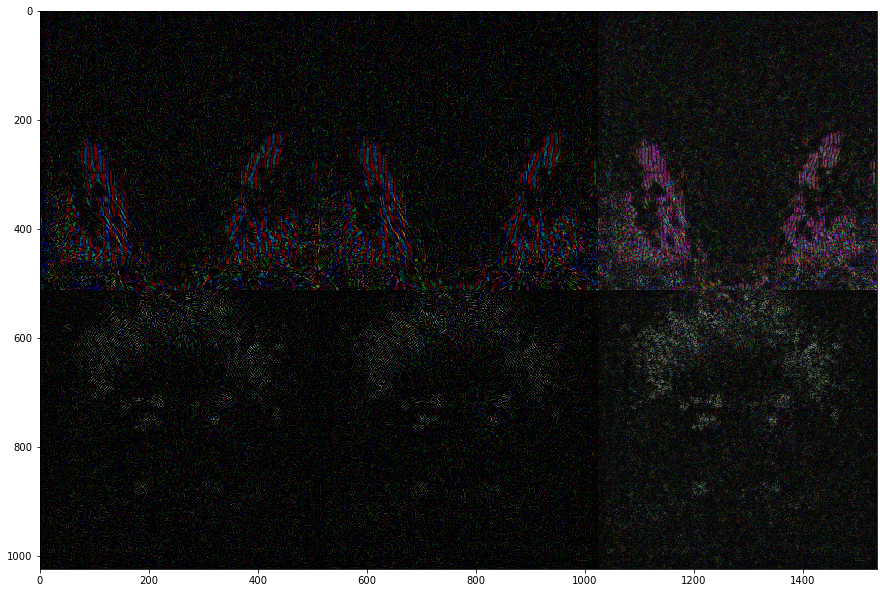

In [54]:
print(M.mem_dimgs.shape)
dimgs = M.mem_dimgs.unbind(dim=0)
to_show = torch.cat(dimgs[2:4], dim=1).cpu()
show(torch.cat([to_show.relu(), (-to_show).relu(), to_show.abs()], dim=2))
#show(torch.cat(dimgs[2:4], dim=1).cpu())
#clip_neg_show(torch.cat(dimgs[:2], dim=1).cpu())